# Monocular Depth Estimation

## Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/RGB_KITTI.zip", 'r')
# zip_ref.extractall("/content")
# zip_ref.close()

###Extracing dataset

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/nyu_data.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


##loading all dependencies and libraries

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2DTranspose

In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model
# from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow as tf

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


##Resnet Encoder

In [ ]:
# GRADED FUNCTION: identity_block

def identity_block_encoder(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3,(1,1),strides=(1,1),padding='valid',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:
# GRADED FUNCTION: convolutional_block

def convolutional_block_encoder(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters =F1, kernel_size =(1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters =F2, kernel_size =(f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path (≈2 lines)
    X = Conv2D(filters =F3, kernel_size =(1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters =F3, kernel_size =(1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:

def ResNet50_encoder(X_input, classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1_z', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block_encoder(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block_encoder(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block_encoder(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block_encoder(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block_encoder(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block_encoder(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block_encoder(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    # X = convolutional_block_encoder(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    # X = identity_block_encoder(X, 3, [256, 256, 1024], stage=4, block='b')
    # X = identity_block_encoder(X, 3, [256, 256, 1024], stage=4, block='c')
    # X = identity_block_encoder(X, 3, [256, 256, 1024], stage=4, block='d')
    # X = identity_block_encoder(X, 3, [256, 256, 1024], stage=4, block='e')
    # X = identity_block_encoder(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    # X = convolutional_block_encoder(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    # X = identity_block_encoder(X, 3, [512, 512, 2048], stage=5, block='b')
    # X = identity_block_encoder(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"   
    # model = Model(inputs = X_input, outputs = X, name='ResNet50')

    # return model
    return X

In [ ]:
# X_input = Input((240, 320, 3))
# model_out = ResNet50_encoder(X_input=X_input)
# model = Model(inputs = X_input, outputs = model_out)
# print(model.summary())

In [ ]:
# # loading resnet50 model using tensorflow
# model2=tf.keras.applications.ResNet50(
#     include_top=False, weights='imagenet', input_tensor=None,
#     input_shape=(240, 320, 3), pooling=None, 
# )
# model2.summary()

## Resnet Decoder Model


In [ ]:
# GRADED FUNCTION: identity_block

def identity_block_decoder(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2DTranspose(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a_dec', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a_dec')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2DTranspose(F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2DTranspose(F3,(1,1),strides=(1,1),padding='valid',kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1)(X)

    # X_shortcut = Conv2DTranspose(F3,(1,1),strides=(1,1),padding='valid',kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:
# GRADED FUNCTION: convolutional_block

def convolutional_block_decoder(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2DTranspose(filters =F1, kernel_size =(1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a_dec', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a_dec')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2DTranspose(filters =F2, kernel_size =(f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b_dec', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b_dec')(X)
    X = Activation('relu')(X)
    
    # Third component of main path (≈2 lines)
    X = Conv2DTranspose(filters =F3, kernel_size =(1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c_dec', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c_dec')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2DTranspose(filters =F3, kernel_size =(1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1_dec', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1_dec')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [ ]:
def ResNet50_decoder(encoder_output, classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    # X_input = Input(input_shape)

    # Stage 5 (≈3 lines)
    X = convolutional_block_decoder(encoder_output, f = 3, filters = [512, 512, 2048], stage = 5, block='a_dec', s = 2)
    X = identity_block_decoder(X, 3, [512, 512, 2048], stage=5, block='c_dec')
    X = identity_block_decoder(X, 3, [512, 512, 2048], stage=5, block='b_dec')
    
    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    # Stage 4 (≈6 lines)
    X = convolutional_block_decoder(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a_dec', s = 2)
    X = identity_block_decoder(X, 3, [256, 256, 1024], stage=4, block='f_dec')
    X = identity_block_decoder(X, 3, [256, 256, 1024], stage=4, block='e_dec')
    X = identity_block_decoder(X, 3, [256, 256, 1024], stage=4, block='d_dec')
    X = identity_block_decoder(X, 3, [256, 256, 1024], stage=4, block='c_dec')
    X = identity_block_decoder(X, 3, [256, 256, 1024], stage=4, block='b_dec')
    

    # Stage 3 (≈4 lines)
    X = convolutional_block_decoder(X, f = 3, filters = [128, 128, 512], stage = 3, block='a_dec', s = 2)

    X = identity_block_decoder(X, 3, [128, 128, 512], stage=3, block='d_dec')
    X = identity_block_decoder(X, 3, [128, 128, 512], stage=3, block='c_dec')
    X = identity_block_decoder(X, 3, [128, 128, 512], stage=3, block='b_dec')
    # X = tf.keras.layers.Resizing(60, 80, interpolation='bilinear')(X)    


    # # Stage 2

    # X = convolutional_block_decoder(X, f = 3, filters = [64, 64, 256], stage = 2, block='a_dec', s = 1)
    # X = identity_block_decoder(X, 3, [64, 64, 256], stage=2, block='c_dec')
    # X = identity_block_decoder(X, 3, [64, 64, 256], stage=2, block='b_dec')



    # # Stage 1
    # print("stage1")
    # X = Conv2DTranspose(64, (1, 1), strides = (2, 2), name = 'conv1_dec',padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)


    
    X = Conv2DTranspose(1, (1, 1), strides = (1, 1), name = 'conv2_dec', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1_dec')(X)
    X = Activation('sigmoid')(X)
    # Zero-Padding
    # X = ZeroPadding2D((3, 3))(X)
    # model_enc = ResNet50_encoder(input_shape = (240, 320, 3))
    # model_dec = ResNet50_decoder(model_enc.output)

    # depth_model=Model(inputs=model.input,outputs=model_dec)

    
    return X

## Connecting encoder and decoder models

In [ ]:
def depth_model(input_shape=(240,320)):

    # put the code below out of this function
    ''' Building depth model from Resnet50_encoder to Resnet50_output'''
    X_input = Input((240, 320, 3))
    model_enc = ResNet50_encoder(X_input=X_input)
    model_dec = ResNet50_decoder(encoder_output=model_enc)

    depth_model=Model(inputs=X_input, outputs = model_dec)
    
    return depth_model


## Building Depth Model

In [ ]:
input_shape = (224,320,3)
depth_model= depth_model(input_shape= input_shape)

In [ ]:
depth_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 246, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_z (Conv2D)                (None, 120, 160, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 120, 160, 64) 256         conv1_z[0][0]                    
______________________________________________________________________________________________

##Plotting Depth Estimation model

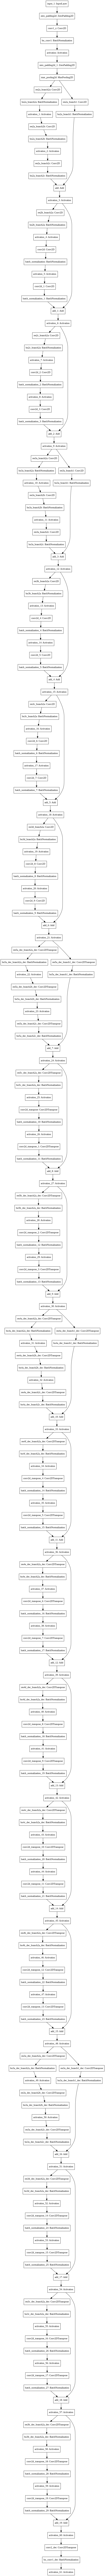

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(depth_model)

##Loading Dataset using Custom Data Generator

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import os
import json


class DataGenerator(Sequence):
    def __init__(self, x_data, y_depth,
                 batch_size=32, input_dim=(640,480),output_dim =(640,4800),
                 shuffle=True):
        self.x_data = x_data
        self.y_depth = y_depth
        # self.y_semantic = y_semantic
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.output_dim = output_dim


    def __len__(self):
        return int(np.floor(len(self.x_data) / self.batch_size))


    def __getitem__(self, index):
        start_index = index * self.batch_size
        x_train = []
        y_train_depth = []
        # y_train_semantic = []
        i = start_index - 1
        while len(x_train) < self.batch_size:
            try:
                img = cv2.imread(self.x_data[i % len(self.x_data)])
                img = cv2.resize(img,self.input_dim)
                img = img / 255.0
              
                y_depth = cv2.imread(self.y_depth[i%len(self.y_depth)])
                y_depth = cv2.cvtColor(y_depth,cv2.COLOR_BGR2GRAY)
                y_depth = cv2.resize(y_depth, self.output_dim)
                
                y_depth = y_depth / 255.0
                # print(y_depth)
                x_train.append(img)
                y_train_depth.append(y_depth)
                i += 1
            except Exception as err:
                print(err)
                continue

        return np.array(x_train),np.array(y_train_depth)

## Here you can change no of images parameters for loading different no of images

In [ ]:
no_of_images = 1000


In [ ]:

import numpy as np
import os
import cv2
dir = '/content/data/nyu2_train'
img_paths = []
depth_paths = []
for i in os.listdir(dir):
  for j in os.listdir(dir + '/' + i):
    if len(img_paths) >= no_of_images:
      break
    if j[-4:] == '.jpg':
      img_path = dir + '/' + i + '/' + j
      depth_path = dir + '/' + i + '/' + j[:-4] + '.png'
      img_paths.append(img_path)
      depth_paths.append(depth_path)


img_paths = np.array(img_paths)
depth_paths = np.array(depth_paths)

In [ ]:
# print(img_paths)
print(len(depth_paths))

1000


In [ ]:
train_data = DataGenerator(img_paths, depth_paths, batch_size=1, input_dim=(320, 240),output_dim =(320, 240))

## load Weights after training Model

In [ ]:
# weights_path = ""
# depth_model.load_weights(weights_path)

## evaluation Matices

In [ ]:
def ABS_REL(y_true, y_pred):
  '''
  absolute relative error
  y_true: ground truth image
  y_pred: predicted image
  '''
  y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
  y_pred = tf.convert_to_tensor(y_pred, dtype = tf.float32)
  error = (y_pred - y_true) / y_true
  error = tf.math.abs(error)*100
  error = tf.reduce_mean(error)
  return error


In [ ]:
def RMS(y_true, y_pred):
    '''
    Root mean square error
    y_true: ground truth image
    y_pred: predicted image
    '''
    y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype = tf.float32)
    rms = tf.math.pow((y_true - y_pred), 2)
    rms = tf.reduce_mean(rms)
    rms = tf.math.sqrt(rms)
    return rms

In [ ]:
def RMSE_LOG(y_true, y_pred):
    '''
    Root mean square log error
    y_true: ground truth image
    y_pred: predicted image
    '''   
    y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype = tf.float32)
    y_true = tf.math.log(y_true) 
    y_pred = tf.math.log(y_pred)
    rms_log = tf.math.pow((y_true - y_pred), 2)
    rms_log = tf.reduce_mean(rms_log)
    return rms_log

In [ ]:
def Sq_Rel(y_true, y_pred):
    y=y_true
    y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype = tf.float32)
    y = tf.convert_to_tensor(y, dtype = tf.float32)
    sq_rel = (y_true - y_pred)
    sq_rel = tf.math.pow(tf.math.abs(sq_rel), 2)
    sq_rel = sq_rel / y
    sq_rel = tf.reduce_mean(sq_rel)
    return sq_rel

In [ ]:
def delta_error(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype = tf.float32)
    yOverZ = tf.math.divide(y_true, y_pred)
    zOverY = tf.math.divide(y_pred,y_true)
    thresh = tf.math.maximum(yOverZ, zOverY)
    delta1 = tf.cast((thresh < 1.25) , dtype='float32', name=None) 
    # print(delta1)
    delta1  =tf.reduce_mean(delta1)
    return delta1  

In [ ]:
def delta2_error(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype = tf.float32)
    yOverZ = tf.math.divide(y_true, y_pred)
    zOverY = tf.math.divide(y_pred,y_true)
    thresh = tf.math.maximum(yOverZ, zOverY)
    delta2 = tf.cast((thresh < 1.25) , dtype='float32', name=None) 
    # print(delta1)
    delta2  =tf.reduce_mean(delta2)
    return delta2

In [ ]:
def delta3_error(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype = tf.float32)
    yOverZ = tf.math.divide(y_true, y_pred)
    zOverY = tf.math.divide(y_pred,y_true)
    thresh = tf.math.maximum(yOverZ, zOverY)
    delta3 = tf.cast((thresh < 1.25**3) , dtype='float32', name=None) 
    # print(delta1)
    delta3  =tf.reduce_mean(delta3)
    return delta3

##Setting hyperparameters

In [ ]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.0001)

In [ ]:
depth_model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError(),metrics=[ABS_REL, RMS, RMSE_LOG, Sq_Rel, delta_error, delta2_error, delta3_error])

In [ ]:
# os.mkdir("/content/drive/MyDrive/checkpoints/")

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/checkpoints/train_{epoch}.tf", verbose = 1,
                                                save_weights_only=True)]    

##Model Training

In [ ]:
history = depth_model.fit(train_data, epochs = 1,  verbose=1, callbacks = callbacks)

   77/10000 [..............................] - ETA: 126:36:35 - loss: 0.0617 - ABS_REL: 111.1024 - RMS: 0.2421 - RMSE_LOG: 0.6963 - Sq_Rel: 0.3438 - delta_error: 0.1685 - delta2_error: 0.1685 - delta3_error: 0.5447

##Evaluation on test data

In [ ]:
no_of_test_images=1000

In [ ]:

import numpy as np
import os
import cv2
dir = '/content/data/nyu2_test'
test_img_paths = []
test_depth_paths = []
for i in os.listdir(dir):
  if i[-10:] == 'colors.png':
      if(len(test_img_paths)>no_of_test_images):
        break
      img_path = dir + '/' + i 
      depth_path = dir + '/' + i[:-10] + 'depth.png'
      test_img_paths.append(img_path)
      test_depth_paths.append(depth_path)


test_img_paths = np.array(test_img_paths)
test_depth_paths = np.array(test_depth_paths)

In [ ]:
print(len(test_img_paths))
print(len(test_depth_paths))

In [ ]:
test_data = DataGenerator(test_img_paths, test_depth_paths, batch_size=4, input_dim=(320, 240),output_dim =(320, 240))

In [ ]:
results = depth_model.evaluate(test_data, batch_size=128)

163/163 [==============================] - 366s 2s/step - loss: 0.1961 - ABS_REL: 1377.0631 - RMS: 0.4425 - RMSE_LOG: 6.8518 - Sq_Rel: 6.1863 - delta_error: 0.0000e+00 - delta2_error: 0.0000e+00 - delta3_error: 0.0000e+00


In [ ]:

# output = depth_model.predict(test_data, batch_size=)

##Results Visulazation

In [ ]:
# '''for evaluation simply call function for every image'''
# absolute_relative_error = ABS_REL(depth_map, output[...,0])

In [ ]:
img_path = "/content/data/nyu2_test/00000_colors.png"
depth_map_path = "/content/data/nyu2_test/00000_depth.png"
img = cv2.imread(img_path)
img = cv2.resize(img,(320,240))
img = img / 255.0
depth_map = cv2.imread(depth_map_path)
depth_map = cv2.resize(depth_map,(320,240))
depth_map = cv2.cvtColor(depth_map,cv2.COLOR_BGR2GRAY)
img = np.expand_dims(img, axis=0)
output = depth_model.predict(img)[0]

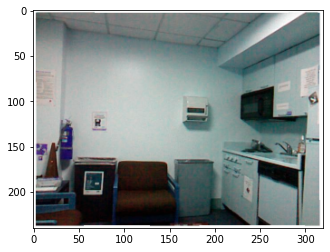

In [ ]:
plt.imshow(img[0])

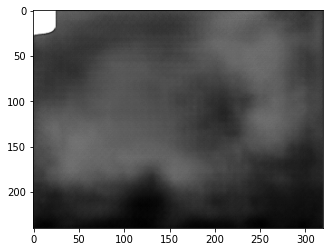

In [ ]:
plt.imshow(output[...,0],cmap='gray')

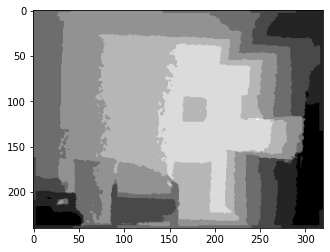

In [ ]:
plt.imshow(depth_map,cmap='gray')